In [10]:
import numpy as np
import pandas as pd
#import geopandas as gp
import matplotlib.pyplot as plt
import folium
import json

In [138]:
nl_covid = pd.read_csv('../data/Raw/corona/nl_corona.csv',sep='\t')
weather = pd.read_csv('../data/Raw/weather/weather.csv',sep='\t')
with open('../data/Raw/metadata/nl_metadata.json') as f:
    metadata = json.load(f)
nl_weather = weather['iso3166-2'].str[:2] == 'NL'
nl_weather_df = weather[nl_weather]
nl_weather_df
#missing data?
#print(nl_weather_df.isna().any().any())
nl_weather_df
reg_dict = {}
names = {}
for i in metadata['country_metadata']:
    reg_dict[int(i['covid_region_code'])] = [i['population']]
    names[int(i['covid_region_code'])] = i['iso3166-2_code']
    

reg_names = set(nl_covid['region_code'])
mask1 = nl_covid['confirmed_addition'].dropna()
mask_idk = nl_covid['confirmed_addition'].notnull()

#print(4344-sum(mask_idk))
for i in list(reg_names):
    mask = (nl_covid['region_code'] == i) & (nl_covid['confirmed_addition'].notnull())
    mask_covid=nl_covid[mask]
    reg_dict[i].append(sum(mask_covid['confirmed_addition']))
df1 = pd.DataFrame.from_dict(reg_dict)
df1 = df1.transpose()
df1.rename(names)

,0,1
NL-DR,493657.0,21039.0
NL-FL,422979.0,25315.0
NL-FR,649944.0,25271.0
NL-GE,2086142.0,119495.0
NL-GR,586061.0,23161.0
NL-LI,1117164.0,69949.0
NL-NB,2563432.0,166862.0
NL-NH,2879611.0,180576.0
NL-OV,1162500.0,74359.0
NL-UT,1354979.0,84449.0


In [46]:
nl_covid

,date,region_name,region_code,deceased_addition,confirmed_addition,hospitalized_addition,deceased_cumulative,confirmed_cumulative,hospitalized_cumulative
0,2020-02-27,Drenthe,22,NaN,NaN,NaN,NaN,0,NaN
1,2020-02-27,Flevoland,24,NaN,NaN,NaN,NaN,0,NaN
2,2020-02-27,Friesland,21,NaN,NaN,NaN,NaN,0,NaN
3,2020-02-27,Gelderland,25,NaN,NaN,NaN,NaN,0,NaN
4,2020-02-27,Groningen,20,NaN,NaN,NaN,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...
4339,2021-02-22,Noord-Holland,27,6.0,821.0,12.0,2206.0,180576,3666.0
4340,2021-02-22,Overijssel,23,1.0,197.0,2.0,1018.0,74359,1125.0
4341,2021-02-22,Utrecht,26,1.0,291.0,4.0,1111.0,84449,1971.0
4342,2021-02-22,Zeeland,29,1.0,77.0,1.0,171.0,15987,456.0


In [4]:
'''Finding min, median, max and mean for each numerical value, for each region in the Netherlands.'''
#print(nl_weather_df['iso3166-2'].unique())
num_columns = ['RelativeHumiditySurface','SolarRadiation','Surfacepressure','TemperatureAboveGround','Totalprecipitation','UVIndex','WindSpeed']
reg_dict = {}
for i in nl_weather_df['iso3166-2'].unique():
    reg_dict[i] = {}
    for j in num_columns:
        reg_dict[i][j] = {'min': min(nl_weather_df[nl_weather_df['iso3166-2'] == i][j]),'median':np.median(nl_weather_df[nl_weather_df['iso3166-2'] == i][j]),'max':max(nl_weather_df[nl_weather_df['iso3166-2'] == i][j]),'mean':np.mean(nl_weather_df[nl_weather_df['iso3166-2'] == i][j])}
#reg_dict['NL-GE']['RelativeHumiditySurface']

In [5]:
num_columns = ['RelativeHumiditySurface','SolarRadiation','Surfacepressure','TemperatureAboveGround','Totalprecipitation','UVIndex','WindSpeed']
date_dict = {}
for i in nl_weather_df['date'].unique():
    date_dict[i] = {}
    for j in num_columns:
        date_dict[i][j] = np.mean(nl_weather_df[nl_weather_df['date'] == i][j])
#date_dict

<BarContainer object of 12 artists>

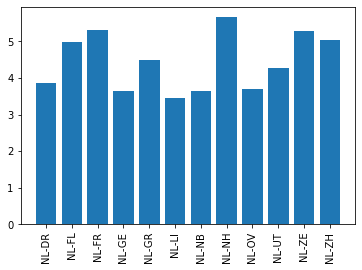

In [6]:
#Plotting means of windspeeds for different regions
means = [reg_dict[i]['WindSpeed']['mean'] for i in reg_dict.keys()]

plt.xticks(rotation=90)
plt.bar(reg_dict.keys(),means)

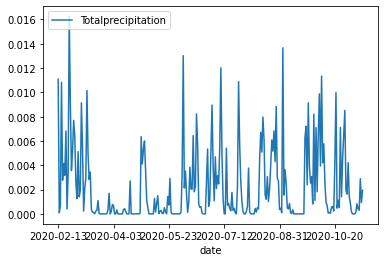

In [7]:
weather_by_day_nl = nl_weather_df.groupby(by = "date").mean()

weather_by_day_nl.loc[:, "Totalprecipitation"].plot.line().legend(loc = "upper left")

In [8]:
nl_map = folium.Map(location = [52.3,5.5], zoom_start = 7.4)
folium.GeoJson('../Data/Raw/shapefiles/nl.geojson', name = "geojson").add_to(nl_map)
folium.LayerControl().add_to(nl_map)

nl_map